In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Autoencoders (AEs)

Autoencoders are a type of neural network architecture used for unsupervised learning. They consist of an encoder and a decoder, which work together to learn a compressed representation of input data. The encoder compresses the input data into a lower-dimensional latent space (codings), while the decoder reconstructs the original input data from the compressed representation.

Autoencoders have been used for applications such as dimensionality reduction, feature learning, data denoising, and anomaly detection.

This notebook provides examples of how to implement multiple kinds of autoencoders (AEs).

## PCA Using a Simple Undercomplete Autoencoder

The term "Undercomplete autoencoder" refers to a type of autoencoder where the dimensionality of the hidden layer (also known as the code or latent space) is lower than the dimensionality of the input. This means that the autoencoder is tasked with learning a compressed representation of the input in the hidden layer, forcing it to capture only the most essential features of the data. Undercomplete autoencoders are commonly used for dimensionality reduction and feature learning tasks, where the goal is to extract meaningful and compact representations of the input data.

As mentioned in the lecture, an undercomplete linear autoencoder with no activations is equivalent to Principal Component Analysis (PCA). Here is how PCA is used to reduce the dimensionality of the IRIS dataset from 4 to 2. Notice how the classes are almost totally separable.

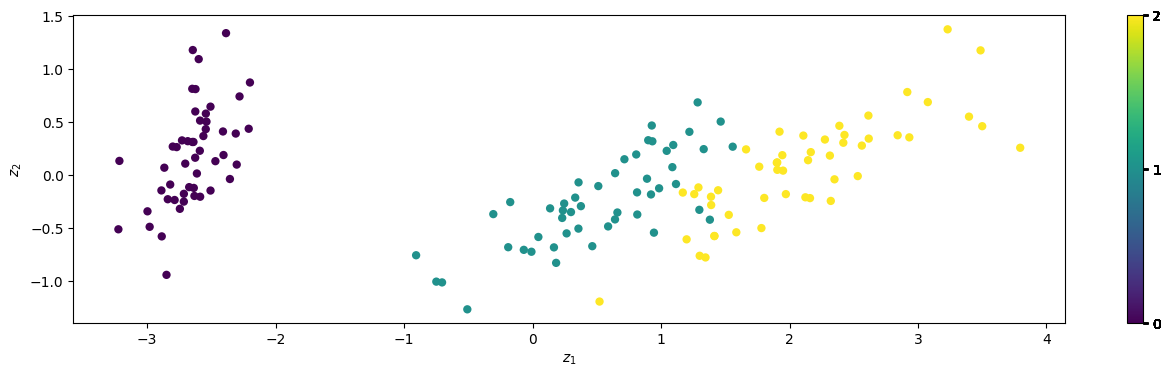

In [2]:
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target

pca = PCA(n_components=2)
X_projected = pca.fit_transform(X)

fig = plt.figure(figsize=(16, 4))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, edgecolor='none')
cb = plt.colorbar()
cb.set_ticks(y)

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.show()

Let's build a linear autoencoder consisting of an encoder and a decoder, with each being a separate model. The encoder will have a hidden 'codings' linear layer without an activation function. The number of units in the codings layer should match how much we want to reduce the dimensionality of the input by (2 in this example). The output layer of the decoder should have as many units as the dimensionality of the input (4 in this example).

For loss calculation, we will use the mean squared error (MSE), and for optimization, we will use stochastic gradient descent. Although a metric function can be provided, it is not necessary in this case.

In [3]:
from torchinfo import summary

encoder = nn.Linear(4, 2)
decoder = nn.Linear(2, 4)

autoencoder = nn.Sequential(encoder, decoder)

summary(autoencoder, input_size=[1, 4], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 4]                    --
├─Linear: 1-1                            [1, 2]                    10
├─Linear: 1-2                            [1, 4]                    12
Total params: 22
Trainable params: 22
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

We can use Lightning, or we could create our own training loop. Let's do the latter for the sake of review. Take your time with this code (below) and make sure you understand every piece of it.

In [4]:
def training_step(model, x_batch, y_batch, metric):
    pred = model(x_batch)
    loss = loss_fn(pred, y_batch)
    metric(pred, y_batch)
    
    return loss
    
def validation_step(model, x_batch, y_batch, metric):
    pred = model(x_batch)
    loss = loss_fn(pred, y_batch)
    metric(pred, y_batch)
    
    return loss
    
def train(model, loss_fn, optimizer, metric, dl_train, dl_val=None, val_metric=None, epochs=10,
         training_step=training_step, validation_step=validation_step):
    hist = dict(loss=[0] * epochs, metric=[0] * epochs)
    
    if dl_val is not None:
        hist['val_loss'] = [0] * epochs
        hist['val_metric'] =[0] * epochs
    
    for epoch in range(epochs):
        for x_batch, _ in dl_train: # Ignoring the labels
            loss = training_step(model, x_batch, x_batch, metric)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            hist['loss'][epoch] += loss.item()
        
        hist['loss'][epoch] /= len(dl_train)
        hist['metric'][epoch] = metric.compute().item()
        metric.reset()
        
        output = f"Epoch{epoch + 1: 3d}/{epochs}: loss={hist['loss'][epoch]:.4f}, metric={hist['metric'][epoch]:.4f}"
        if dl_val is not None:
            with torch.no_grad():
                for x_batch, _ in dl_val: # Ignoring the labels
                    loss = validation_step(model, x_batch, x_batch, val_metric)
                    hist['val_loss'][epoch] += loss.item()
            
            hist['val_loss'][epoch] /= len(dl_val)
            hist['val_metric'][epoch] = val_metric.compute().item()
            val_metric.reset()
        
            output += f", val_loss={hist['val_loss'][epoch]:.4f}, val_metric={hist['val_metric'][epoch]:.4f}"

        if epochs // 10 < 5 or (epoch == 0 or (epoch + 1) % 10 == 0):
            print(output)

    return hist

Next we standardize the input data and create a training dataset.

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader

std_scaler = StandardScaler()
X = torch.from_numpy(std_scaler.fit_transform(X)).float()

ds_train = TensorDataset(X, X)
dl_train = DataLoader(ds_train, shuffle=True, batch_size=4)

We are now ready to train this autoencoder model.  We'll use the mean squared error (MSE) as both loss and metric.

In [6]:
from torchmetrics.regression import MeanSquaredError

loss_fn = nn.MSELoss()
metric = MeanSquaredError()
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.01)

hist = train(autoencoder, loss_fn, optimizer, metric, dl_train, epochs=20)

Epoch  1/20: loss=1.0396, metric=1.0429
Epoch  2/20: loss=0.7695, metric=0.7692
Epoch  3/20: loss=0.6247, metric=0.5979
Epoch  4/20: loss=0.4753, metric=0.4797
Epoch  5/20: loss=0.4006, metric=0.4031
Epoch  6/20: loss=0.3477, metric=0.3499
Epoch  7/20: loss=0.3090, metric=0.3115
Epoch  8/20: loss=0.2847, metric=0.2815
Epoch  9/20: loss=0.2595, metric=0.2548
Epoch 10/20: loss=0.2330, metric=0.2301
Epoch 11/20: loss=0.2028, metric=0.2047
Epoch 12/20: loss=0.1784, metric=0.1794
Epoch 13/20: loss=0.1550, metric=0.1540
Epoch 14/20: loss=0.1292, metric=0.1293
Epoch 15/20: loss=0.1092, metric=0.1071
Epoch 16/20: loss=0.0877, metric=0.0884
Epoch 17/20: loss=0.0735, metric=0.0738
Epoch 18/20: loss=0.0629, metric=0.0631
Epoch 19/20: loss=0.0563, metric=0.0556
Epoch 20/20: loss=0.0508, metric=0.0506


Let's put the original data `X` next to the reconstructed input that the autoencoder generated so we can see how close they are.

In [7]:
pd.DataFrame(torch.concat([X, autoencoder(X).detach()], axis=1), 
            columns=list(iris.feature_names) + list([name + "-reonstructed" for name in iris.feature_names]))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length (cm)-reonstructed,sepal width (cm)-reonstructed,petal length (cm)-reonstructed,petal width (cm)-reonstructed
0,-0.900681,1.019004,-1.340227,-1.315444,-1.025315,1.018580,-1.262757,-1.239383
1,-1.143017,-0.131979,-1.340227,-1.315444,-1.247795,0.033726,-1.243602,-1.185691
2,-1.385353,0.328414,-1.397064,-1.315444,-1.322773,0.385059,-1.400632,-1.348259
3,-1.506521,0.098217,-1.283389,-1.315444,-1.377058,0.165002,-1.400803,-1.340512
4,-1.021849,1.249201,-1.340227,-1.315444,-1.057080,1.191095,-1.334948,-1.314516
...,...,...,...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,1.155933,-0.181296,1.146993,1.104673
146,0.553333,-1.282963,0.705921,0.922303,0.613378,-1.133253,0.846802,0.852258
147,0.795669,-0.131979,0.819596,1.053935,0.905812,-0.174811,0.902040,0.870549
148,0.432165,0.788808,0.933271,1.448832,0.997295,0.478690,0.834694,0.782753


And here are the learning curves:

<Axes: >

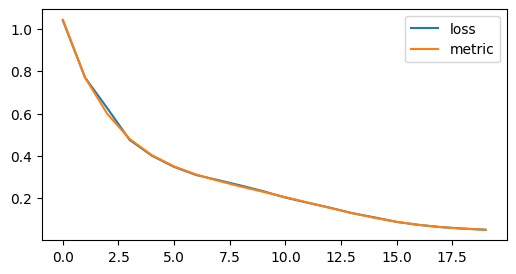

In [8]:
pd.DataFrame(hist).plot(figsize=(6,3))

Let's also visualize the "codings" output of the encoder:

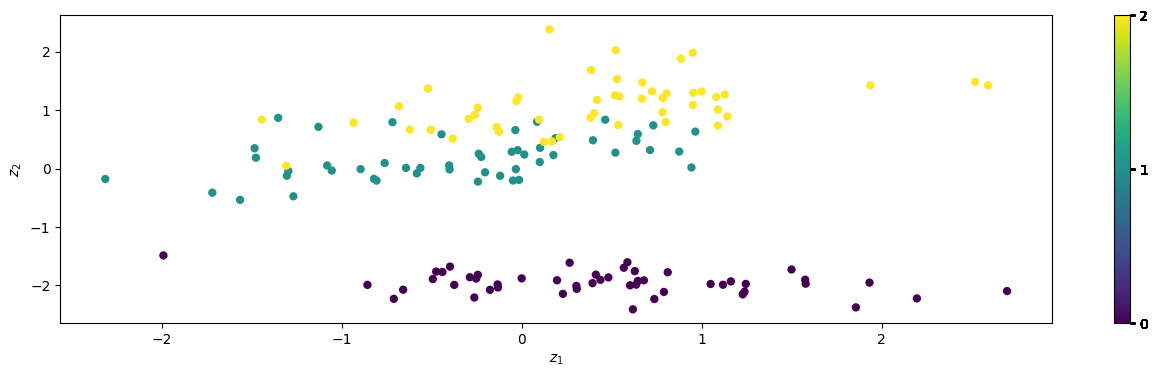

In [9]:
codings = encoder(X).detach()

fig = plt.figure(figsize=(16, 4))
plt.scatter(codings[:, 0], codings[:, 1], c=y, edgecolor='none')
cb = plt.colorbar()
cb.set_ticks(y)

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.show()

As you can see, the autoencoder model has separated the classes almost as cleanly as the PCA model shown above. However, the points themselves are different, which is perfectly fine. What matters here is the outcome - a clear separation between classes.

## Stacked Autoencoders
Next, we will build a stacked autoencoder with multiple Linear layers that use ReLU activation for both the encoder and decoder. We will evaluate this autoencoder using the MNIST dataset.

In [10]:
encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(), 
    nn.Linear(100, 16),
    nn.ReLU()
)

decoder = nn.Sequential(
    nn.Linear(16, 100),
    nn.ReLU(), 
    nn.Linear(100, 28 * 28),
    nn.Unflatten(1, (1, 28, 28))
)

# Weight initialization
nn.init.zeros_(encoder[1].bias)
nn.init.kaiming_uniform_(encoder[1].weight)
nn.init.zeros_(encoder[3].bias)
nn.init.kaiming_uniform_(encoder[3].weight)
nn.init.zeros_(decoder[0].bias)
nn.init.kaiming_uniform_(decoder[0].weight)

autoencoder = nn.Sequential(encoder, decoder)

Please note the use of the `nn.Unflatten` layer at the end of the decoder, which essentially reverses the action of the Flatten layer used at the beginning of the encoder. 

To evaluate this model, let's load the MNIST dataset, scale it, and then split it into the two sets:

In [11]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

data_path='./datasets'

ds_train_mnist = datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
ds_val_mnist = datasets.MNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

X_train = torch.stack([x for x, _ in ds_train_mnist])
X_val = torch.stack([x for x, _ in ds_val_mnist])

dl_train_mnist = DataLoader(ds_train_mnist, batch_size=32, shuffle=True, num_workers=2)
dl_val_mnist = DataLoader(ds_val_mnist, batch_size=32, shuffle=False, num_workers=2)

len(dl_train_mnist), len(dl_val_mnist)

(1875, 313)

We can now train the above autoencoder.

In [12]:
loss_fn = nn.MSELoss()
metric = MeanSquaredError()
val_metric = MeanSquaredError()
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=0.001)

hist = train(autoencoder, loss_fn, optimizer, metric, dl_train_mnist, 
             dl_val=dl_val_mnist, val_metric=val_metric, epochs=10)

Epoch  1/10: loss=0.0457, metric=0.0457, val_loss=0.0365, val_metric=0.0365
Epoch  2/10: loss=0.0335, metric=0.0335, val_loss=0.0309, val_metric=0.0309
Epoch  3/10: loss=0.0301, metric=0.0301, val_loss=0.0290, val_metric=0.0290
Epoch  4/10: loss=0.0289, metric=0.0289, val_loss=0.0279, val_metric=0.0279
Epoch  5/10: loss=0.0274, metric=0.0274, val_loss=0.0266, val_metric=0.0266
Epoch  6/10: loss=0.0266, metric=0.0266, val_loss=0.0261, val_metric=0.0261
Epoch  7/10: loss=0.0261, metric=0.0261, val_loss=0.0255, val_metric=0.0255
Epoch  8/10: loss=0.0257, metric=0.0257, val_loss=0.0252, val_metric=0.0252
Epoch  9/10: loss=0.0254, metric=0.0254, val_loss=0.0251, val_metric=0.0251
Epoch 10/10: loss=0.0252, metric=0.0252, val_loss=0.0252, val_metric=0.0252


Here are the training curves.

<Axes: >

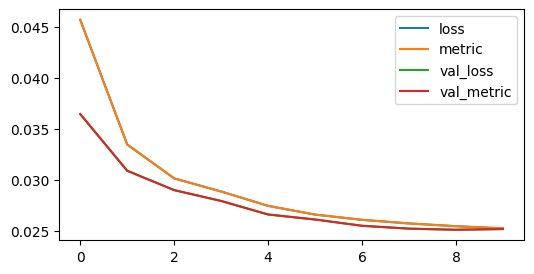

In [13]:
pd.DataFrame(hist).plot(figsize=(6,3))

Let's take a look at what the reconstructed inputs look like for the first ten images of the validation set. To ensure that the values produced by the model are valid, scaled colors between 0 and 1, we will first use the `torch.clip` function.

In [14]:
reconstructed_images = torch.clip(autoencoder(X_val[:10]).detach(), 0, 1)
reconstructed_images.shape

torch.Size([10, 1, 28, 28])

We can now plot the original images (row 1) alongside their reconstructions (row 2).

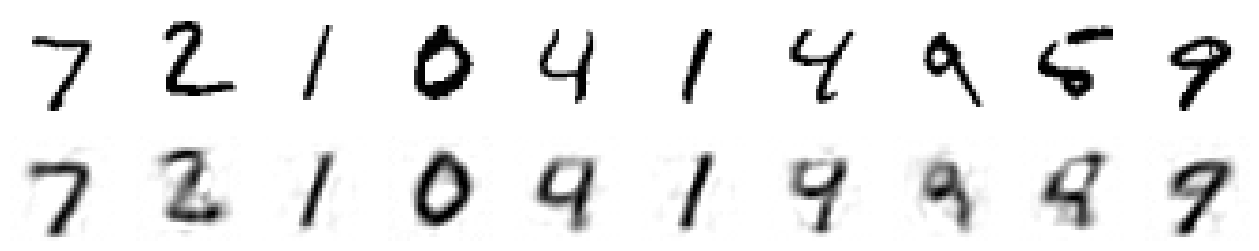

In [15]:
from PIL import Image

fig = plt.figure(figsize=(16, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    img = Image.fromarray(np.uint8(X_val[i].squeeze() * 255))
    plt.imshow(img, cmap="binary")
    plt.axis("off")
    plt.subplot(2, 10, i + 11)
    img = Image.fromarray(np.uint8(reconstructed_images[i].squeeze() * 255))
    plt.imshow(img, cmap="binary")
    plt.axis("off")

plt.show()

The reconstructions look blurry, but that is not bad considering the fact that images were reconstructed from just 16 numbers, instead of 784.

## Denoising Autoencoders

Denoising autoencoders are similar to stacked autoencoders, except that noise is added to the input before it is passed to the encoder. There are two ways to add noise:

* Creating a random vector and adding it to the input before passing it to the encoder.
* Adding a dropout layer to the encoder before the first hidden layer.

Here is a simple denoising autoencoder that uses a dropout layer:

In [16]:
encoder = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=.05),
    nn.Linear(784, 100),
    nn.ReLU(), 
    nn.Linear(100, 16),
    nn.ReLU()
)

decoder = nn.Sequential(
    nn.Linear(16, 100),
    nn.ReLU(), 
    nn.Linear(100, 28 * 28),
    nn.Unflatten(1, (1, 28, 28))
)

# Weight initialization
nn.init.zeros_(encoder[2].bias)
nn.init.kaiming_uniform_(encoder[2].weight)
nn.init.zeros_(encoder[4].bias)
nn.init.kaiming_uniform_(encoder[4].weight)
nn.init.zeros_(decoder[0].bias)
nn.init.kaiming_uniform_(decoder[0].weight)

autoencoder = nn.Sequential(encoder, decoder)

Let's train this model.

In [17]:
loss_fn = nn.MSELoss()
metric = MeanSquaredError()
val_metric = MeanSquaredError()
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=0.001)

hist = train(autoencoder, loss_fn, optimizer, metric, dl_train_mnist, 
             dl_val=dl_val_mnist, val_metric=val_metric, epochs=10)

Epoch  1/10: loss=0.0504, metric=0.0504, val_loss=0.0377, val_metric=0.0377
Epoch  2/10: loss=0.0358, metric=0.0358, val_loss=0.0339, val_metric=0.0339
Epoch  3/10: loss=0.0321, metric=0.0321, val_loss=0.0301, val_metric=0.0301
Epoch  4/10: loss=0.0297, metric=0.0297, val_loss=0.0289, val_metric=0.0289
Epoch  5/10: loss=0.0286, metric=0.0286, val_loss=0.0280, val_metric=0.0280
Epoch  6/10: loss=0.0280, metric=0.0280, val_loss=0.0276, val_metric=0.0276
Epoch  7/10: loss=0.0276, metric=0.0276, val_loss=0.0271, val_metric=0.0271
Epoch  8/10: loss=0.0272, metric=0.0272, val_loss=0.0268, val_metric=0.0268
Epoch  9/10: loss=0.0270, metric=0.0270, val_loss=0.0266, val_metric=0.0266
Epoch 10/10: loss=0.0268, metric=0.0268, val_loss=0.0265, val_metric=0.0265


Here are the training curves.

<Axes: >

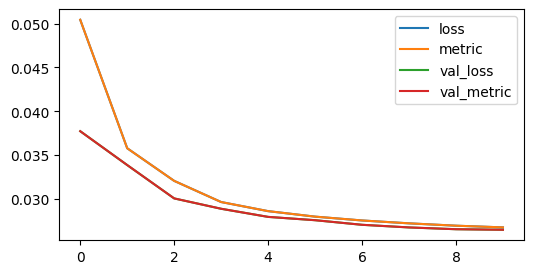

In [18]:
pd.DataFrame(hist).plot(figsize=(6,3))

To see what is reconstructed from noisy images, we need to create a dropout layer and use it to add noise to our validation images. Since dropout layers only work during training, we will need to call `train()` on the dropout layer before when using it to add noise to the validation images.

In [19]:
dropout = nn.Dropout(p=0.5)
dropout.train()
noisy_images  = dropout(X_val[:10])

reconstructed_images = torch.clip(autoencoder(noisy_images).detach(), 0, 1)
reconstructed_images.shape

torch.Size([10, 1, 28, 28])

We can now plot the original images (row 1) alongside their reconstructions (row 2).

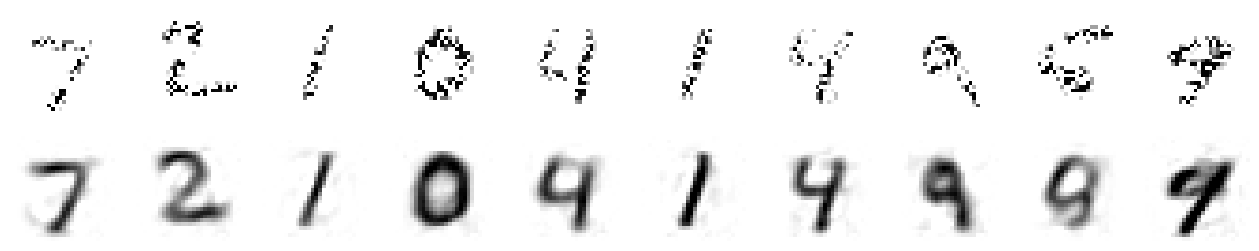

In [20]:
fig = plt.figure(figsize=(16, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    img = Image.fromarray(np.uint8(noisy_images[i].squeeze() * 255))
    plt.imshow(img, cmap="binary")
    plt.axis("off")
    plt.subplot(2, 10, i + 11)
    img = Image.fromarray(np.uint8(reconstructed_images[i].squeeze() * 255))
    plt.imshow(img, cmap="binary")
    plt.axis("off")

plt.show()

Again not bad!

## Convolutional Autoencoders

Autoencoders can be created using convolutional layers, which are useful when we want to process images without flattening them, as we have done before. We can utilize regular convolutional and max-pooling layers to implement the encoder. However, this approach will not work for the decoder because, unlike the encoder, the decoder needs to incrementally increase the width and height of the image while decreasing its depth (number of feature maps). To address this issue, the decoder uses transposed convolutions without any pooling layers. But what are transposed convolutions?

Well! Transposed convolutions, also known as deconvolutions or fractionally strided convolutions, are operations used for upsampling or increasing the spatial resolution of feature maps. They work by reversing the process of standard convolution operations, mapping input pixels to a larger grid of output pixels. This is achieved by inserting zeros between input pixels and applying the convolution operation with learned weights. Transposed convolutions are commonly used in tasks such as image generation, image segmentation, and image super-resolution, where increasing the spatial resolution of feature maps is necessary.

Below is an example of a convolutional encoder using the CIFAR-10 dataset, where each image has the shape of (32, 32, 3).

Here is the encoder. There is nothing out of the ordinary here.

In [21]:
encoder = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten()
)

summary(encoder, input_size=[1, 3, 32, 32], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 32]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           448
├─ReLU: 1-2                              [1, 16, 32, 32]           --
├─MaxPool2d: 1-3                         [1, 16, 16, 16]           --
├─Conv2d: 1-4                            [1, 32, 16, 16]           4,640
├─ReLU: 1-5                              [1, 32, 16, 16]           --
├─MaxPool2d: 1-6                         [1, 32, 8, 8]             --
├─Conv2d: 1-7                            [1, 64, 8, 8]             18,496
├─ReLU: 1-8                              [1, 64, 8, 8]             --
├─MaxPool2d: 1-9                         [1, 64, 4, 4]             --
├─Conv2d: 1-10                           [1, 32, 4, 4]             18,464
├─ReLU: 1-11                             [1, 32, 4, 4]             --
├─AdaptiveAvgPool2d: 1-12                [1, 32, 1, 1]             --
├─F

The encoder above results in a vector of 32 values for every image.

And here is the decoder with transposed convolution layers. Note that the parameters given to these layers are selected so as to recreate images of the same shape as the input. They will need to change if input images with different dimensions are used. Notice also the use of the `Reshape` layers.

In [22]:
decoder = nn.Sequential(
    nn.Linear(32, 4 * 4 * 16),
    nn.Unflatten(1, (16, 4, 4)),
    nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=2, output_padding=1),
    # nn.Unflatten(1, (3, 32, 32))
)

summary(decoder, input_size=[1, 32], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3, 32, 32]            --
├─Linear: 1-1                            [1, 256]                  8,448
├─Unflatten: 1-2                         [1, 16, 4, 4]             --
├─ConvTranspose2d: 1-3                   [1, 32, 8, 8]             2,080
├─ReLU: 1-4                              [1, 32, 8, 8]             --
├─ConvTranspose2d: 1-5                   [1, 16, 17, 17]           4,624
├─ReLU: 1-6                              [1, 16, 17, 17]           --
├─ConvTranspose2d: 1-7                   [1, 3, 32, 32]            435
Total params: 15,587
Trainable params: 15,587
Non-trainable params: 0
Total mult-adds (M): 1.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.06
Estimated Total Size (MB): 0.14

Finally here is the autoencoder model that puts these sub-models together.

In [23]:
autoencoder = nn.Sequential(encoder, decoder)
summary(autoencoder, input_size=[1, 3, 32, 32], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 32, 8, 8]             --
│    └─Conv2d: 2-7                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-8                         [1, 64, 8, 8]             --
│    └─MaxPool2d: 2-9                    [1, 64, 4, 4]             --
│    └─Conv2d: 2-10                      [1, 32, 4, 4]             18,464
│    └─ReLU: 2-11                        [1, 32, 4, 4]             --
│  

To train this model, we first download and split the CIFAR10 dataset.

In [24]:
ds_train_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
ds_val_cifar10 = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

X_train = torch.stack([x for x, _ in ds_train_cifar10])
X_val = torch.stack([x for x, _ in ds_val_cifar10])

dl_train_cifar10 = DataLoader(ds_train_cifar10, batch_size=32, shuffle=True, num_workers=2)
dl_val_cifar10 = DataLoader(ds_val_cifar10, batch_size=32, shuffle=False, num_workers=2)

len(dl_train_cifar10), len(dl_val_cifar10)

100%|██████████| 170498071/170498071 [00:02<00:00, 57901906.70it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


(1563, 313)

We now train this model.

In [25]:
loss_fn = nn.MSELoss()
metric = MeanSquaredError()
val_metric = MeanSquaredError()
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=0.001)

hist = train(autoencoder, loss_fn, optimizer, metric, dl_train_cifar10, 
             dl_val=dl_val_cifar10, val_metric=val_metric, epochs=10)

Epoch  1/10: loss=0.0406, metric=0.0406, val_loss=0.0296, val_metric=0.0296
Epoch  2/10: loss=0.0264, metric=0.0264, val_loss=0.0247, val_metric=0.0247
Epoch  3/10: loss=0.0220, metric=0.0220, val_loss=0.0220, val_metric=0.0220
Epoch  4/10: loss=0.0197, metric=0.0197, val_loss=0.0263, val_metric=0.0263
Epoch  5/10: loss=0.0184, metric=0.0184, val_loss=0.0189, val_metric=0.0189
Epoch  6/10: loss=0.0175, metric=0.0175, val_loss=0.0169, val_metric=0.0169
Epoch  7/10: loss=0.0169, metric=0.0169, val_loss=0.0165, val_metric=0.0165
Epoch  8/10: loss=0.0164, metric=0.0164, val_loss=0.0157, val_metric=0.0157
Epoch  9/10: loss=0.0160, metric=0.0160, val_loss=0.0157, val_metric=0.0157
Epoch 10/10: loss=0.0157, metric=0.0157, val_loss=0.0162, val_metric=0.0162


Here are the training curves.

<Axes: >

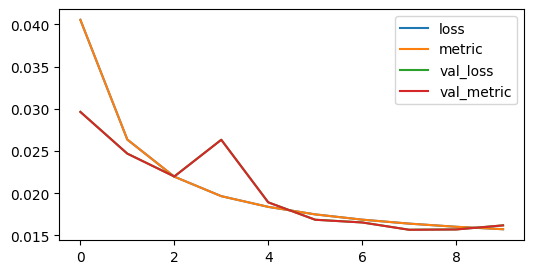

In [26]:
pd.DataFrame(hist).plot(figsize=(6,3))

Let's see some reconstructed images just like we did before.

torch.Size([10, 3, 32, 32])


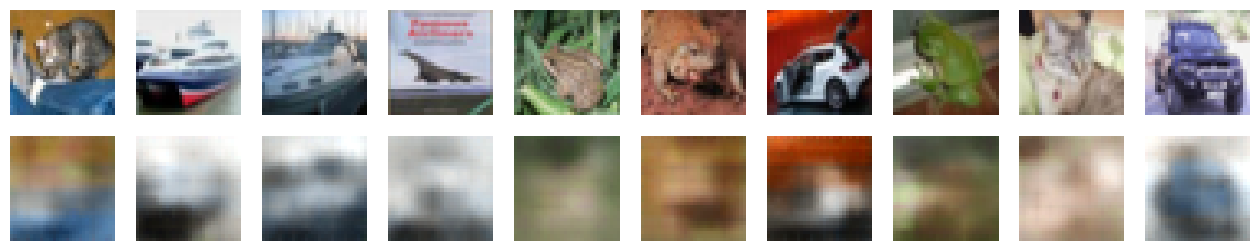

In [27]:
reconstructed_images = torch.clip(autoencoder(X_val[:10]).detach(), 0, 1)
print(reconstructed_images.shape)

fig = plt.figure(figsize=(16, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    img = Image.fromarray(np.uint8(X_val[i].permute(1, 2, 0) * 255))
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(2, 10, i + 11)
    img = Image.fromarray(np.uint8(reconstructed_images[i].permute(1, 2, 0) * 255))
    plt.imshow(img)
    plt.axis("off")

plt.show()

As we can see, the reconstructed images are very blurry. A larger model and more training could help improve the results.